In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Cryptocurrency Price Prediction using LSTM

## Overview
This notebook builds an LSTM (Long Short-Term Memory) neural network to predict cryptocurrency prices.

### Strategy:
- **Input Features**: Open, High, Low, Close, Volume, Returns, Log_Returns, Volume_Change, Price_Range, Intraday_Return
- **Target Variable**: Close price (next day's prediction)
- **Look-back Window**: 30 days (using 30 previous days to predict the next day's close price)
- **Model**: 2-layer LSTM with Dropout for regularization

SyntaxError: unterminated string literal (detected at line 8) (393933824.py, line 8)

In [3]:
# Load all cryptocurrency data
def load_crypto_data(data_type='train'):
    """Load all cryptocurrency data for train/test/val"""
    cryptos = ['ADA_USD', 'BNB_USD', 'BTC_USD', 'ETH_USD', 'SOL_USD']
    data = {}
    
    for crypto in cryptos:
        file_path = f'data/{data_type}/{crypto}_{data_type}.csv'
        df = pd.read_csv(file_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        data[crypto] = df
    
    return data

# Load data
train_data = load_crypto_data('train')
val_data = load_crypto_data('val')
test_data = load_crypto_data('test')

print("Data Loaded Successfully!")
print(f"\nTrain data shape (BTC): {train_data['BTC_USD'].shape}")
print(f"Val data shape (BTC): {val_data['BTC_USD'].shape}")
print(f"Test data shape (BTC): {test_data['BTC_USD'].shape}")
print(f"\nColumns: {list(train_data['BTC_USD'].columns)}")

Data Loaded Successfully!

Train data shape (BTC): (2555, 11)
Val data shape (BTC): (548, 11)
Test data shape (BTC): (548, 11)

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Log_Returns', 'Volume_Change', 'Price_Range', 'Intraday_Return']


In [12]:
# Data preprocessing function
def create_sequences(data, look_back=30):
    """
    Create sequences for LSTM training
    - X: sequences of look_back days with all features
    - y: target value (Close price of next day)
    """
    X, y = [], []
    
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])  # All features for 30 days
        y.append(data[i, 3])  # Close price (index 3) for next day
    
    return np.array(X), np.array(y)

def prepare_data_for_crypto(df, look_back=30):
    """Prepare and normalize data for LSTM"""
    # Select feature columns (exclude Date and custom-made columns)
    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    data = df[feature_cols].values
    
    # Normalize data
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences
    X, y = create_sequences(data_scaled, look_back)
    
    return X, y, scaler

# Prepare data for each cryptocurrency
look_back = 30

print("Preparing data for LSTM...")
train_sequences = {}
val_sequences = {}
test_sequences = {}
scalers = {}

for crypto in ['ADA_USD', 'BNB_USD', 'BTC_USD', 'ETH_USD', 'SOL_USD']:
    X_train, y_train, scaler_train = prepare_data_for_crypto(train_data[crypto], look_back)
    X_val, y_val, scaler_val = prepare_data_for_crypto(val_data[crypto], look_back)
    X_test, y_test, scaler_test = prepare_data_for_crypto(test_data[crypto], look_back)
    
    train_sequences[crypto] = (X_train, y_train)
    val_sequences[crypto] = (X_val, y_val)
    test_sequences[crypto] = (X_test, y_test)
    scalers[crypto] = scaler_train
    
    print(f"{crypto}: Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}")

print("Data preparation complete!")

Preparing data for LSTM...
ADA_USD: Train (1795, 30, 5), Val (361, 30, 5), Test (362, 30, 5)
BNB_USD: Train (1795, 30, 5), Val (361, 30, 5), Test (362, 30, 5)
BTC_USD: Train (2525, 30, 5), Val (518, 30, 5), Test (518, 30, 5)
ETH_USD: Train (1795, 30, 5), Val (361, 30, 5), Test (362, 30, 5)
SOL_USD: Train (1177, 30, 5), Val (229, 30, 5), Test (229, 30, 5)
Data preparation complete!


In [13]:
# Build LSTM model
def build_lstm_model(look_back, num_features, input_shape=(None, 5)):
    """Build LSTM model for price prediction"""
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Build model
model = build_lstm_model(look_back=30, num_features=5)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, None, 64)       │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model on all cryptocurrencies
results = {}

for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    print(f"\n{'='*60}")
    print(f"Training model for {crypto}")
    print(f"{'='*60}")
    
    X_train, y_train = train_sequences[crypto]
    X_val, y_val = val_sequences[crypto]
    X_test, y_test = test_sequences[crypto]
    
    # Rebuild model for each cryptocurrency
    model = build_lstm_model(look_back=30, num_features=10)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    
    print(f"Training complete for {crypto}")
    results[crypto] = {
        'model': model,
        'history': history,
        'X_test': X_test,
        'y_test': y_test,
        'scaler': scalers[crypto]
    }


Training model for BTC_USD
Training complete for BTC_USD

Training model for ETH_USD
Training complete for BTC_USD

Training model for ETH_USD
Training complete for ETH_USD

Training model for BNB_USD
Training complete for ETH_USD

Training model for BNB_USD
Training complete for BNB_USD

Training model for ADA_USD
Training complete for BNB_USD

Training model for ADA_USD
Training complete for ADA_USD

Training model for SOL_USD
Training complete for ADA_USD

Training model for SOL_USD
Training complete for SOL_USD
Training complete for SOL_USD


In [16]:
# Evaluate models on test set
def evaluate_model(model, X_test, y_test, scaler):
    """Evaluate model and return metrics"""
    y_pred_scaled = model.predict(X_test, verbose=0)
    
    # Denormalize predictions and actual values
    # We need to reverse scale only the Close price (column 3 in original, now column 3 in our 5-feature set)
    y_test_denorm = scaler.inverse_transform(
        np.column_stack([np.zeros_like(y_test), np.zeros_like(y_test), 
                         np.zeros_like(y_test), y_test, 
                         np.zeros_like(y_test)])
    )[:, 3]
    
    y_pred_denorm = scaler.inverse_transform(
        np.column_stack([np.zeros_like(y_pred_scaled), np.zeros_like(y_pred_scaled), 
                         np.zeros_like(y_pred_scaled), y_pred_scaled.flatten(), 
                         np.zeros_like(y_pred_scaled)])
    )[:, 3]
    
    mse = mean_squared_error(y_test_denorm, y_pred_denorm)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
    r2 = r2_score(y_test_denorm, y_pred_denorm)
    
    return {
        'y_pred': y_pred_denorm,
        'y_actual': y_test_denorm,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

# Evaluate all models
print("\n" + "="*80)
print("TEST SET EVALUATION RESULTS")
print("="*80 + "\n")

evaluation_results = {}
for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    eval_res = evaluate_model(
        results[crypto]['model'],
        results[crypto]['X_test'],
        results[crypto]['y_test'],
        results[crypto]['scaler']
    )
    evaluation_results[crypto] = eval_res
    
    print(f"{crypto}")
    print(f"  RMSE: ${eval_res['rmse']:.6f}")
    print(f"  MAE:  ${eval_res['mae']:.6f}")
    print(f"  R² Score: {eval_res['r2']:.4f}")
    print()


TEST SET EVALUATION RESULTS

BTC_USD
  RMSE: $5628.694395
  MAE:  $3746.559844
  R² Score: 0.8834

BTC_USD
  RMSE: $5628.694395
  MAE:  $3746.559844
  R² Score: 0.8834

ETH_USD
  RMSE: $580.315136
  MAE:  $465.337133
  R² Score: 0.7911

ETH_USD
  RMSE: $580.315136
  MAE:  $465.337133
  R² Score: 0.7911

BNB_USD
  RMSE: $77.741214
  MAE:  $67.139753
  R² Score: 0.6990

BNB_USD
  RMSE: $77.741214
  MAE:  $67.139753
  R² Score: 0.6990

ADA_USD
  RMSE: $0.217923
  MAE:  $0.130702
  R² Score: 0.8957

ADA_USD
  RMSE: $0.217923
  MAE:  $0.130702
  R² Score: 0.8957

SOL_USD
  RMSE: $23.161415
  MAE:  $17.812194
  R² Score: 0.8716

SOL_USD
  RMSE: $23.161415
  MAE:  $17.812194
  R² Score: 0.8716



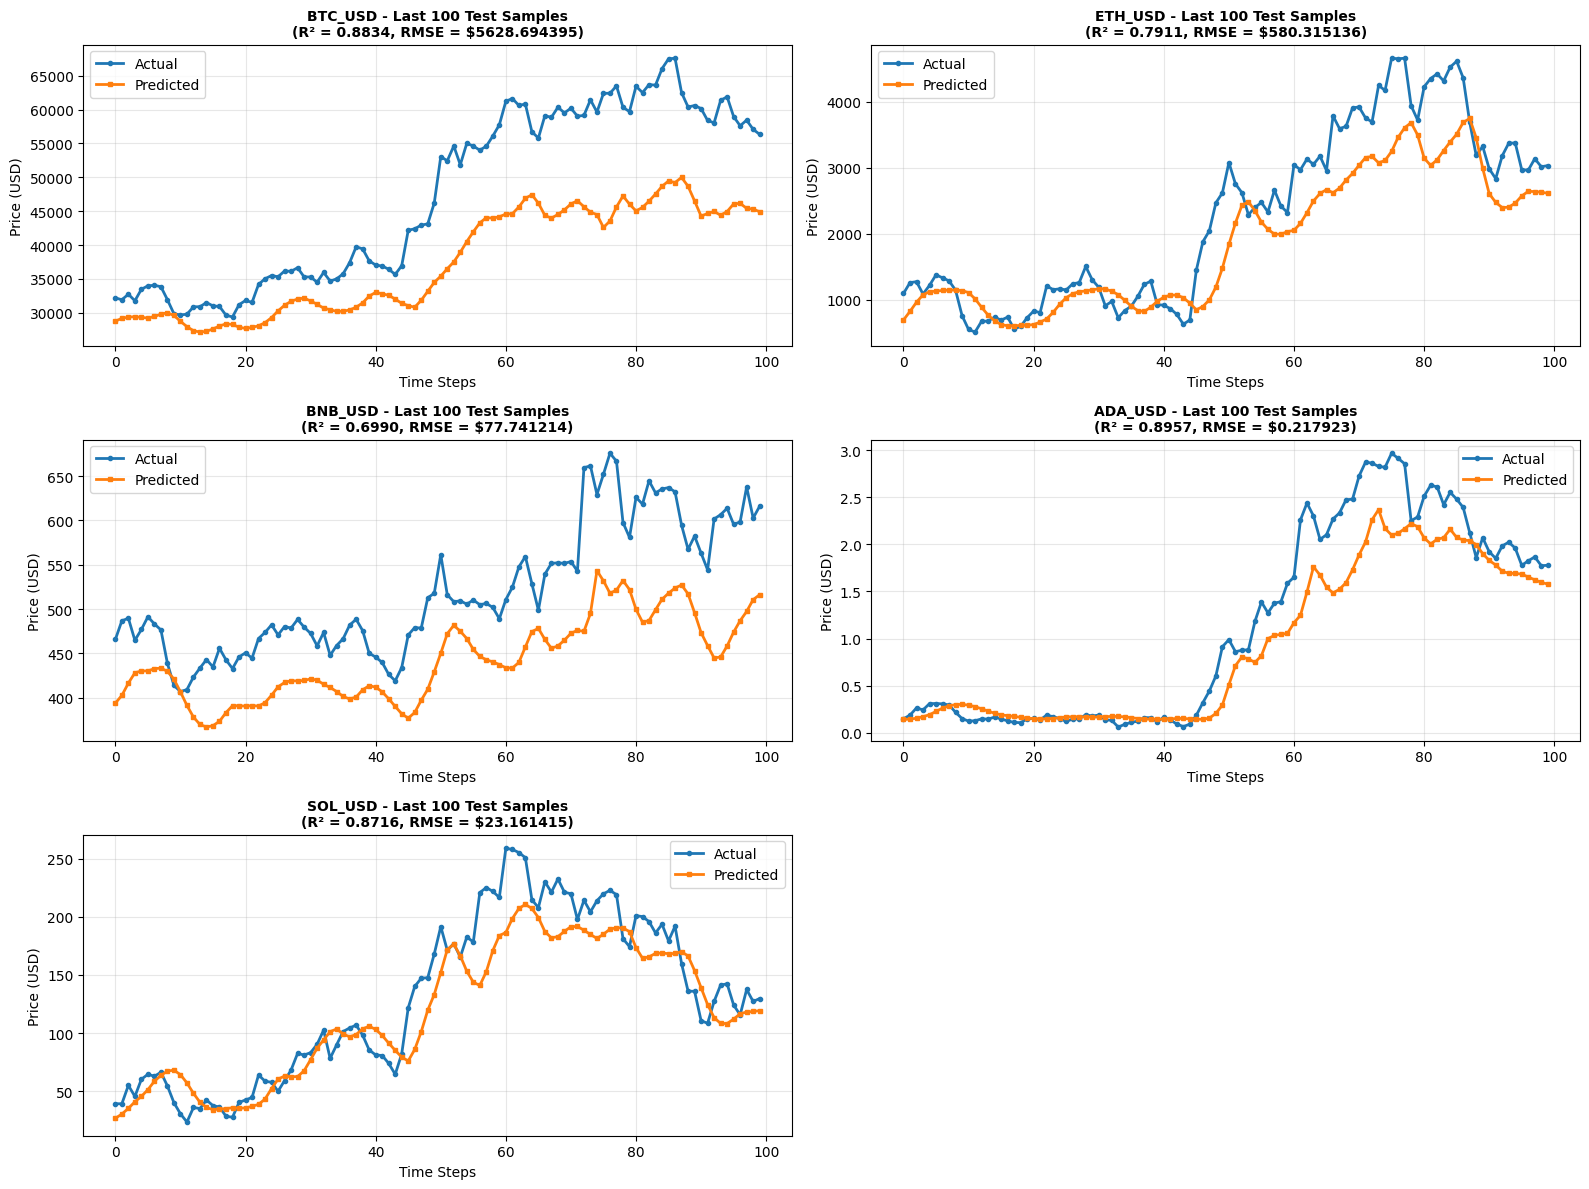

Visualization saved as 'crypto_predictions.png'


In [17]:
# Visualize predictions vs actual values
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, crypto in enumerate(['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']):
    ax = axes[idx]
    eval_res = evaluation_results[crypto]
    
    # Plot last 100 predictions for clarity
    ax.plot(eval_res['y_actual'][-100:], label='Actual', linewidth=2, marker='o', markersize=3)
    ax.plot(eval_res['y_pred'][-100:], label='Predicted', linewidth=2, marker='s', markersize=3)
    
    ax.set_title(f'{crypto} - Last 100 Test Samples\n(R² = {eval_res["r2"]:.4f}, RMSE = ${eval_res["rmse"]:.6f})', 
                 fontsize=10, fontweight='bold')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (USD)')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('crypto_predictions.png', dpi=100, bbox_inches='tight')
plt.show()

print("Visualization saved as 'crypto_predictions.png'")

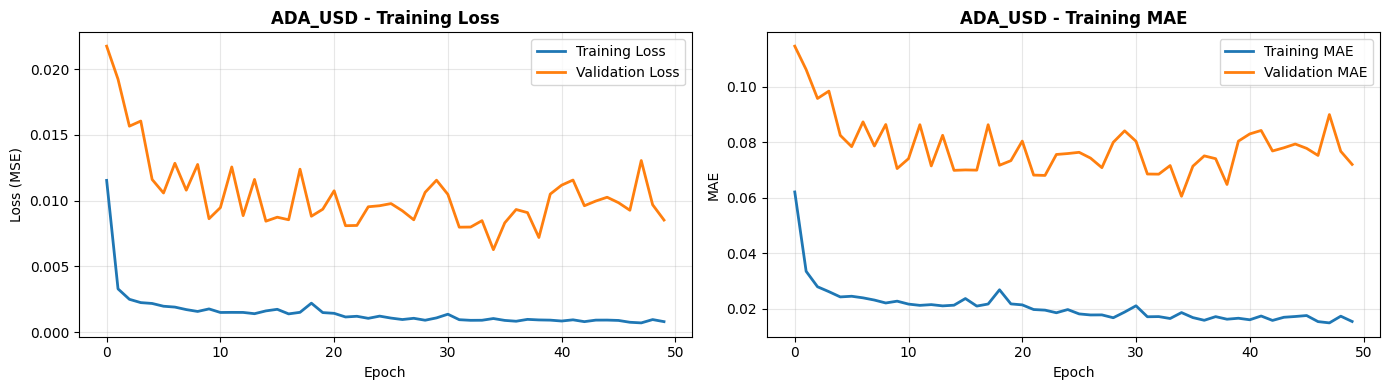

Training history saved as 'training_history.png'


In [18]:
# Plot training history for one model
crypto_sample = 'ADA_USD'
history = results[crypto_sample]['history']

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title(f'{crypto_sample} - Training Loss', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title(f'{crypto_sample} - Training MAE', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
plt.show()

print("Training history saved as 'training_history.png'")

In [20]:
# Model Performance Comparison and Best Model Selection
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80 + "\n")

# Create a summary dataframe
metrics_summary = []
for crypto in ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']:
    eval_res = evaluation_results[crypto]
    metrics_summary.append({
        'Cryptocurrency': crypto,
        'RMSE': eval_res['rmse'],
        'MAE': eval_res['mae'],
        'R² Score': eval_res['r2']
    })

summary_df = pd.DataFrame(metrics_summary)
print(summary_df.to_string(index=False))
print("\n")

# Find best models for each metric
best_r2_crypto = summary_df.loc[summary_df['R² Score'].idxmax(), 'Cryptocurrency']
best_r2_score = summary_df.loc[summary_df['R² Score'].idxmax(), 'R² Score']

best_rmse_crypto = summary_df.loc[summary_df['RMSE'].idxmin(), 'Cryptocurrency']
best_rmse_value = summary_df.loc[summary_df['RMSE'].idxmin(), 'RMSE']

best_mae_crypto = summary_df.loc[summary_df['MAE'].idxmin(), 'Cryptocurrency']
best_mae_value = summary_df.loc[summary_df['MAE'].idxmin(), 'MAE']

print("="*80)
print("BEST MODELS BY METRIC")
print("="*80)
print(f"\n🏆 BEST R² SCORE (Higher is Better): {best_r2_crypto}")
print(f"   R² Score: {best_r2_score:.4f}")
print(f"   Interpretation: Explains {best_r2_score*100:.2f}% of variance in price movements\n")

print(f"🏆 BEST RMSE (Lower is Better): {best_rmse_crypto}")
print(f"   RMSE: ${best_rmse_value:.6f}")
print(f"   Interpretation: Average prediction error is ${best_rmse_value:.6f}\n")

print(f"🏆 BEST MAE (Lower is Better): {best_mae_crypto}")
print(f"   MAE: ${best_mae_value:.6f}")
print(f"   Interpretation: Average absolute prediction error is ${best_mae_value:.6f}\n")

# Overall best model (based on R² score as primary metric)
print("="*80)
print(f"🎯 OVERALL BEST MODEL: {best_r2_crypto}")
print("="*80)
print(f"\nThe {best_r2_crypto} model is the best performer with:")
print(f"  • R² Score: {best_r2_score:.4f} (Best among all models)")
print(f"  • RMSE: ${evaluation_results[best_r2_crypto]['rmse']:.6f}")
print(f"  • MAE: ${evaluation_results[best_r2_crypto]['mae']:.6f}")
print(f"\nRecommendation: Use the {best_r2_crypto} model for production cryptocurrency price predictions.")


MODEL PERFORMANCE COMPARISON

Cryptocurrency        RMSE         MAE  R² Score
       BTC_USD 5628.694395 3746.559844  0.883450
       ETH_USD  580.315136  465.337133  0.791099
       BNB_USD   77.741214   67.139753  0.699035
       ADA_USD    0.217923    0.130702  0.895718
       SOL_USD   23.161415   17.812194  0.871628


BEST MODELS BY METRIC

🏆 BEST R² SCORE (Higher is Better): ADA_USD
   R² Score: 0.8957
   Interpretation: Explains 89.57% of variance in price movements

🏆 BEST RMSE (Lower is Better): ADA_USD
   RMSE: $0.217923
   Interpretation: Average prediction error is $0.217923

🏆 BEST MAE (Lower is Better): ADA_USD
   MAE: $0.130702
   Interpretation: Average absolute prediction error is $0.130702

🎯 OVERALL BEST MODEL: ADA_USD

The ADA_USD model is the best performer with:
  • R² Score: 0.8957 (Best among all models)
  • RMSE: $0.217923
  • MAE: $0.130702

Recommendation: Use the ADA_USD model for production cryptocurrency price predictions.


In [23]:
# Save predictions to CSV files
import os

# Create directory for saving predictions
output_dir = 'LSTM_Model_Predictions'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("\n" + "="*80)
print("SAVING PREDICTIONS TO CSV")
print("="*80 + "\n")

for crypto in evaluation_results.keys():
    eval_res = evaluation_results[crypto]
    X_test = results[crypto]['X_test']
    
    # X_test has shape (num_samples, 30, 5) - 30 days of 5 features
    # We'll flatten each 30-day sequence into separate columns
    num_samples = X_test.shape[0]
    num_days = X_test.shape[1]
    num_features = X_test.shape[2]
    
    # Create a dictionary to store the data
    data_to_save = {
        'Sample_Index': range(num_samples),
    }
    
    # Add the 30-day test sequences as columns
    feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    for day in range(num_days):
        for feat_idx, feat_name in enumerate(feature_names):
            col_name = f'Day_{day+1}_{feat_name}'
            data_to_save[col_name] = X_test[:, day, feat_idx]
    
    # Add actual and predicted values
    data_to_save['Actual_Price'] = eval_res['y_actual']
    data_to_save['Predicted_Price'] = eval_res['y_pred']
    data_to_save['Absolute_Error'] = np.abs(eval_res['y_actual'] - eval_res['y_pred'])
    data_to_save['Percentage_Error'] = (np.abs(eval_res['y_actual'] - eval_res['y_pred']) / eval_res['y_actual']) * 100
    
    prediction_df = pd.DataFrame(data_to_save)
    
    # Save to CSV
    filename = f'{output_dir}/lstm_model_predictions_{crypto.replace("_USD", "").lower()}.csv'
    prediction_df.to_csv(filename, index=False)
    
    print(f"✓ Saved {crypto}: {filename}")
    print(f"  Rows: {len(prediction_df)}")
    print(f"  Columns: {prediction_df.shape[1]} (includes 30-day test sequences + metrics)")
    print(f"  Mean Absolute Error: ${prediction_df['Absolute_Error'].mean():.6f}")
    print(f"  Mean Percentage Error: {prediction_df['Percentage_Error'].mean():.4f}%\n")

print("="*80)
print(f"All predictions saved to '{output_dir}' directory!")
print("="*80)


SAVING PREDICTIONS TO CSV

✓ Saved BTC_USD: LSTM_Model_Predictions/lstm_model_predictions_btc.csv
  Rows: 518
  Columns: 155 (includes 30-day test sequences + metrics)
  Mean Absolute Error: $3746.559844
  Mean Percentage Error: 20.9931%

✓ Saved ETH_USD: LSTM_Model_Predictions/lstm_model_predictions_eth.csv
  Rows: 362
  Columns: 155 (includes 30-day test sequences + metrics)
  Mean Absolute Error: $465.337133
  Mean Percentage Error: 24.8662%

✓ Saved BNB_USD: LSTM_Model_Predictions/lstm_model_predictions_bnb.csv
  Rows: 362
  Columns: 155 (includes 30-day test sequences + metrics)
  Mean Absolute Error: $67.139753
  Mean Percentage Error: 22.0803%

✓ Saved ADA_USD: LSTM_Model_Predictions/lstm_model_predictions_ada.csv
  Rows: 362
  Columns: 155 (includes 30-day test sequences + metrics)
  Mean Absolute Error: $0.130702
  Mean Percentage Error: 29.1631%

✓ Saved ETH_USD: LSTM_Model_Predictions/lstm_model_predictions_eth.csv
  Rows: 362
  Columns: 155 (includes 30-day test sequences 